# A&E attendence overview

Emis-Web has a population reporting sections were reports can be run based on certain criteria. A datadump of recent "Accident and emergancy" is pulled from the population reporting. The data is assumed to always be in this format:



![title](sample.png)

The goal is to visualise this data and see how frequent A&E attenders are and see the spread of the age group that are attending.

In [1]:
import numpy as np
import pandas as pd
import sys
import datetime as dt
from datetime import datetime 
from datetime import datetime, time, date, timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns



#Open the datafile and load into a dataframe:
df = pd.read_csv("data.csv")
df.info()
print("\n\nFirst section of the data: ")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 6 columns):
Age                      2148 non-null float64
Anonymised Identifier    2148 non-null object
Read Code                2148 non-null object
Date                     2148 non-null object
Code Term                2148 non-null object
Unnamed: 5               0 non-null float64
dtypes: float64(2), object(4)
memory usage: 100.8+ KB


First section of the data: 


,Age,Anonymised Identifier,Read Code,Date,Code Term,Unnamed: 5
0,0.0,5deca21a-b3b8-3527-ae41-00a73d00486c,9N19-1,10-Feb-2019,Seen in accident and emergency department,NaN
1,0.0,83ac086b-0f8d-495c-6c22-012288e5aab5,9N19-1,07-Feb-2019,Seen in accident and emergency department,NaN
2,0.0,841984a0-596b-5285-c7d0-036525f29478,9N19-1,28-Jan-2019,Seen in accident and emergency department,NaN
3,0.0,312f0097-d20d-c48f-fa5e-090e3cc77dbe,9N19-1,19-Jan-2019,Seen in accident and emergency department,NaN
4,0.0,312f0097-d20d-c48f-fa5e-090e3cc77dbe,9N19-1,19-Jan-2019,Seen in accident and emergency department,NaN


At a first glance, things we need to clean:
- remove this "Unamed:5" column
- remove any NaN rows
- "Age" column. Turn this into integer
- rename "Anonymised Identifier" to "ID", something easier to manage. 
- Check if "Date" column is in format: datetime

# Cleaning the data

In [2]:
#Drop the "Unnamed:5" column 
del df["Unnamed: 5"]

#Drop any NaN data. Shouldnt be any. 
df = df.dropna()

#fixing the age column:
df = df.astype({"Age": int})

#rename "Anonymised Identifier" to "ID"
df = df.rename(columns={'Anonymised Identifier': 'ID'})

#convert "date" column into datetime from string
df['Date'] =  pd.to_datetime(df['Date'], format='%d-%b-%Y')
#print(type(df.loc[0,"Date"]))
#i = 0
#for datestr in df['Date']:
#    df.loc[i,"Date"] = datetime.strptime(datestr, "%d-%b-%Y").date()
#    i += 1

df.info()
print("\n\nFirst section of the data: ")
df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2148 entries, 0 to 2147
Data columns (total 5 columns):
Age          2148 non-null int32
ID           2148 non-null object
Read Code    2148 non-null object
Date         2148 non-null datetime64[ns]
Code Term    2148 non-null object
dtypes: datetime64[ns](1), int32(1), object(3)
memory usage: 92.3+ KB


First section of the data: 


,Age,ID,Read Code,Date,Code Term
0,0,5deca21a-b3b8-3527-ae41-00a73d00486c,9N19-1,2019-02-10,Seen in accident and emergency department
1,0,83ac086b-0f8d-495c-6c22-012288e5aab5,9N19-1,2019-02-07,Seen in accident and emergency department
2,0,841984a0-596b-5285-c7d0-036525f29478,9N19-1,2019-01-28,Seen in accident and emergency department
3,0,312f0097-d20d-c48f-fa5e-090e3cc77dbe,9N19-1,2019-01-19,Seen in accident and emergency department
4,0,312f0097-d20d-c48f-fa5e-090e3cc77dbe,9N19-1,2019-01-19,Seen in accident and emergency department


# Prepare data for visualization
First we will find the min_date and max_date. 
Then perhaps create a function or have the ability to allow the user to choose their own range, else default to given data range
create new df to store filtered data containing:
| incremental dates  |  count for that date  

Next we will have a list of incremental dates and loop through them. for each date:
- filter by that date and:
    - grab count 
    - grab list of ages 
Then we can use this new df to visualise the data. 

In [3]:
#date range:
mindate = df["Date"].min()
maxdate = df["Date"].max()

print(f"Date ranges from {mindate}  to  {maxdate}  ")
print("Specify your own date range. Otherwise the plots will include all the dates in the data")
##uncomment below as needed and fill year month day:
mindate = datetime(int(2019),int(6),int(7)) # year  month  day
maxdate = datetime(int(2019),int(6),int(14)) # year  month  day

Date ranges from 2019-01-02 00:00:00  to  2019-06-20 00:00:00  
Specify your own date range. Otherwise the plots will include all the dates in the data


In [4]:
#Since we have a possibility of user defined date range, 
#all dates outside the bounds of user date range need to be disregarded. 
df = df.drop(df[df.Date < mindate].index)
df = df.drop(df[df.Date > maxdate].index)
df = df.reset_index(drop=True)

# A list of our dates
datelist = np.arange(mindate, maxdate + timedelta(days=1),timedelta(days=1))

    

#new dataframe to hold our visualisation data. Will contain: Dates (incremental)  |  count of patients per day   |  list of ages
dfmain = pd.DataFrame(datelist, columns=["Dates"])
dfmain["count"] =""
#dfmain["Agelist"] =""


i = 0 
for date in dfmain["Dates"]:
    templist = [] #empty list to store age lsit

    dffilt = df[df.Date == date] # filter data to show only dates in this current increment of date
    count = len(dffilt["Date"]) # grabs the number of occurances on this increment of date
    #for age in dffilt["Age"]: # need to grab list of ages. loop through the age column and grab each data point, appending to a list/ OR DO SERIES TO LIST!!!!!! AND COPY THIS CODE TO GOOGLEKEEP
    #    templist.append(age)

   # AgeStr = ','.join(str(ele) for ele in templist)

    dfmain.loc[i,"count"] = count 
   # dfmain.loc[i,"Agelist"] = AgeStr 
    i += 1


print("Sample of dfmain. This will be used for the final visualisation.")

print(dfmain.head())

Sample of dfmain. This will be used for the final visualisation.
       Dates  count
0 2019-06-07      2
1 2019-06-08      0
2 2019-06-09      1
3 2019-06-10      5
4 2019-06-11      4


In [5]:

#When plotting A swarm plot, seaborn looks at all X values and plots the count
#of Y values. Ofcourse if it cant find a certain X values then it wont plot it. 
#In our case there may be dates with 0 count therefore that date would not be
#included in our swarm plot. but we want to see this is as "zero" on the graph.
#best thing to do is copy the df and search through date range and check if any
#dates are missing the in data (i/e count=0). then just add row with this missing
#date, plug in a ficticious "age" value - so seaborn picks it up, create another col
#called "nullcount" storing "y" or "n" yes means it is a count=0 value. we will
#use nullcount as a hue parameter to "fill" the missing datapoint

#create swarmdf, a df just for the swarm plot. this is a copy of the original
#df however these null dates are added with the age field set to ficticious value.
#also add new col for the hue catagory. set to n (no) for now loop through and change
#to "y" if that date is a nullcount
swarmdf = df
swarmdf["nullcount"] = "n"

#filter df to give only dates where count is zero
dfnulldates = dfmain[(dfmain["count"] == 0)]

#Store these null dates to a list
nulldatelist = []
for nulldate in dfnulldates["Dates"]:
    nulldatelist.append(nulldate)
    

#create swarmdf, a df just for the swarm plot. this is a copy of the original
#df however these null dates are added with the age field set to ficticious value.

#add rows:
for insertdate in nulldatelist:
    swarmdf = swarmdf.append({"Date":insertdate, "Age":1,"nullcount":"y"}, ignore_index="true")
    
#sort by date so we have acending order
swarmdf = swarmdf.sort_values(by='Date',ascending=True)


# The visualization 
We want to take dfmain and visualize it as:
- A bar chart: Count vs Date
- A scatter chart: Age vs date
- A pie chart: overall age distribution 

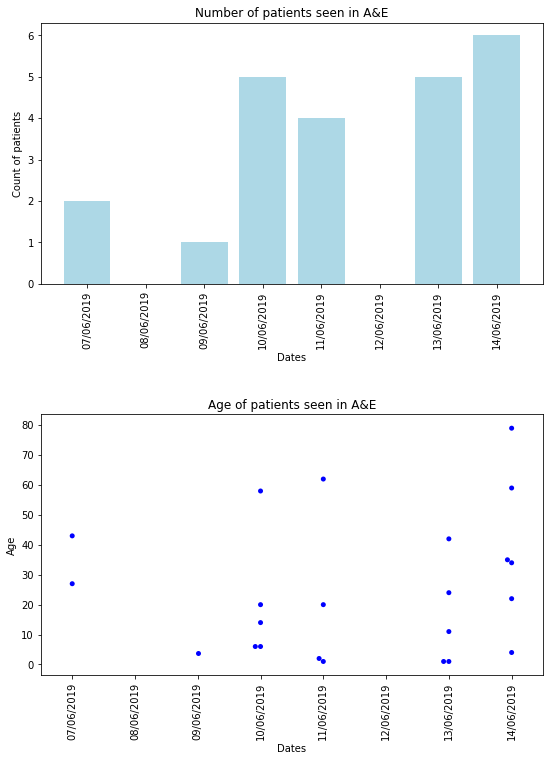

In [6]:
#Prepare the data for bar plot
data = dfmain["Dates"].tolist()
datedata = [date.to_pydatetime().date() for date in data]
fig = plt.figure(figsize=(9,12))

#adjust subplot spacing
fig.subplots_adjust(hspace=0.5)


#bar plot
ax1 = fig.add_subplot(2,1,1)
ax1.set_xticklabels(datedata, rotation=90)
ax1.set_title("Number of patients seen in A&E")
ax1.set_xlabel("Dates")
ax1.set_ylabel("Count of patients")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.bar(datedata,dfmain["count"],color="lightblue")



#Prepare the data for swarm plot
data = swarmdf["Date"].tolist()
datedata = [date.strftime("%d/%m/%Y") for date in data]
y_ages = swarmdf["Age"].tolist()
nullcount = swarmdf["nullcount"].tolist()

#swarm plot
ax2 = fig.add_subplot(2,1,2)
ax2.set_title("Age of patients seen in A&E")
ax2.set_xlabel("Dates")
ax2.set_ylabel("Age")
ax2.set_xticklabels(datedata, rotation=90)

sns.swarmplot(x=datedata,y=y_ages,ax=ax2,hue=nullcount, palette=dict(n="b", y="w"))
ax2.legend_.remove()

fig.savefig(f'ane-{mindate.date()}_to_{maxdate.date()}.png')